In [1]:
import cv2
import numpy as np 
import pandas as pd 
import os
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as pre
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'


2023-06-26 18:26:43.976287: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 18:26:44.098987: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-26 18:26:44.551385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda-11.6/lib64:/home/gil/anaconda3/envs/LeeYS/lib/
2023-06-26 18:26:44.551532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

In [2]:
input_img_size = (704,768, 3)
pd_img_list=pd.read_csv('../../data/original_dataset/data_set.csv')['file_path']
img_list=pd_img_list.to_list()
pd_label_list=pd.read_csv('../../data/original_dataset/data_set.csv')['standard_frame']
label_list=pd_label_list.to_list()

In [3]:
size=256
x = np.zeros((len(img_list),size,size,3))
y = np.zeros((len(label_list),1))
for i in range(len(img_list)):
    x[i] =np.array(Image.open('../../data/original_dataset/'+img_list[i]).resize((size,size)))
x=x/255
y=np.array(label_list)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [4]:

checkpoint_filepath = "../../model/resnet50_original_checkpoints_{epoch:03d}.tf"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only= True
)
class_weight = {1:0.15,0:0.85}
mirrored_strategy = tf.distribute.MirroredStrategy(devices=['/GPU:0','/GPU:1'])
with mirrored_strategy.scope(): 
    input_t=K.Input(shape=(size,size, 3))
    input_tensor = layers.experimental.preprocessing.Resizing(size, size, interpolation="bilinear", input_shape=x_train.shape[1:])(input_t)
    ResNet=ResNet50(include_top=True,weights='imagenet',input_tensor=input_tensor)
    model = K.models.Sequential()
    model.add(ResNet)
    model.add(tf.keras.layers.Dropout(.2, input_shape=(64,)))
    model.add(K.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.1)))
    model.add(K.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=K.optimizers.Adam(lr=1e-4),
                  loss=tf.keras.losses.binary_crossentropy,
                  metrics=["accuracy"])
    histo=model.fit(
        x_train,y_train,
        validation_data=(x_test,y_test),
        epochs=500,
        callbacks=[model_checkpoint_callback],
        batch_size=64,shuffle=True,
        class_weight=class_weight
    )
model.save('../../model/ResNet50_original256.h5')

2023-06-26 18:28:30.808676: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 18:28:31.844882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38153 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0
2023-06-26 18:28:31.847030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38153 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/500
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 218 all-reduces with algorithm = nccl, num_packs = 1


2023-06-26 18:28:58.035931: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-06-26 18:28:58.775660: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-06-26 18:28:59.572007: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


102/102 [==============================] - 39s 203ms/step - loss: 0.4725 - accuracy: 0.8401 - val_loss: 0.6705 - val_accuracy: 0.8408
Epoch 2/500
102/102 [==============================] - 16s 158ms/step - loss: 0.4257 - accuracy: 0.8485 - val_loss: 0.6519 - val_accuracy: 0.8408
Epoch 3/500
102/102 [==============================] - 18s 172ms/step - loss: 0.3863 - accuracy: 0.8485 - val_loss: 0.6314 - val_accuracy: 0.8408
Epoch 4/500
102/102 [==============================] - 17s 165ms/step - loss: 0.3462 - accuracy: 0.8485 - val_loss: 0.6087 - val_accuracy: 0.8408
Epoch 5/500
102/102 [==============================] - 17s 168ms/step - loss: 0.3087 - accuracy: 0.8485 - val_loss: 0.5853 - val_accuracy: 0.8408
Epoch 6/500
102/102 [==============================] - 17s 170ms/step - loss: 0.2700 - accuracy: 0.8485 - val_loss: 0.5634 - val_accuracy: 0.8408
Epoch 7/500
102/102 [==============================] - 18s 173ms/step - loss: 0.2407 - accuracy: 0.8485 - val_loss: 0.5435 - val_accurac

51/51 [==============================] - 1s 23ms/step


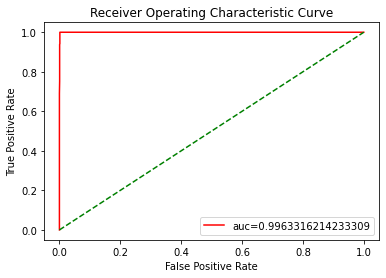

                  precision    recall  f1-score   support

NotStandardFrame       1.00      0.99      1.00      1363
   StandardFrame       0.96      1.00      0.98       258

        accuracy                           0.99      1621
       macro avg       0.98      1.00      0.99      1621
    weighted avg       0.99      0.99      0.99      1621



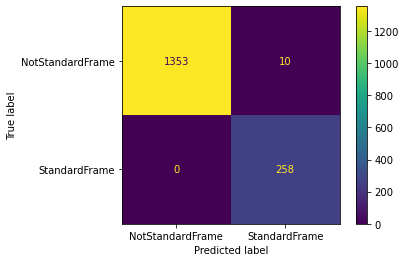

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
def plot_roc_curve(fper, tper):
    
    plt.plot(fper, tper, color='red', label='auc='+str(auc_score))
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()
cmap = plt.cm.Blues
classes = ['NotStandardFrame','StandardFrame']
prob = model.predict(x_test)
t_prob=np.where(prob>0.5,1,0)
fper, tper, thresholds = roc_curve(y_test, prob)
auc_score=roc_auc_score(y_test, t_prob)
plot_roc_curve(fper, tper)
cm = confusion_matrix(y_test, t_prob)
cm_display = ConfusionMatrixDisplay(cm,
                              display_labels=classes).plot()


# F1 점수, 재현율, 정밀도 계산
report = classification_report(y_test, t_prob, target_names=classes)

# 결과 출력
print(report)